In [1]:
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load ranked analysis with domains

ranked_df = pd.read_csv('./results/ranked_analysis_with_domains.csv', sep=',')
ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
0,S-EPMC6040727,1.5,1.333333,1.333333,1.2,0.000000,0.000000,1.333333,1.333333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
1,Mendeley_pzp26k9fy7,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.400000,1.400000,0.000000,0.0,0.0,0.000000,0.000000,AIDS,immunology
2,DRYAD_doi.org:10.5061:dryad.9r35r,0.0,0.000000,3.666667,11.0,22.000000,11.000000,0.000000,7.333333,22.0,22.000000,22.000000,2.444444,11.0,22.0,22.000000,22.000000,AIDS,immunology
3,veupathdb_DS_e8c4cf2187,0.0,0.000000,0.000000,0.0,2.200000,3.666667,0.000000,0.000000,0.0,1.833333,3.666667,0.000000,0.0,0.0,0.000000,1.100000,AIDS,immunology
4,Dataverse_10.5064_F6SF2T3N,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.857143,2.166667,0.000000,0.0,0.0,2.600000,4.333333,AIDS,immunology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,ZENODO_5044544,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.300000,1.625000,zika microcephaly,infectious disease
477,ZENODO_5008681,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.700000,zika microcephaly,infectious disease
478,S-EPMC6256666,1.7,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.000000,0.0,0.000000,0.000000,1.700000,0.0,0.0,0.000000,0.000000,zika microcephaly,infectious disease
479,IMMPORT_SDY1515_2,0.0,0.000000,0.000000,0.0,6.333333,9.500000,0.000000,0.000000,0.0,3.800000,9.500000,0.000000,0.0,0.0,2.375000,3.800000,sublingual immunotherapy,allergy


In [3]:
combination_order = ['original', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
                     'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13',
                     'c14', 'c15']

In [4]:
def compute_scores(df, combination_order):
    final_df = pd.DataFrame()

    for combi in combination_order:
        df_comb = df[['search term', combi]].copy()
        df_comb_sum = df_comb.groupby('search term').sum().reset_index()
        if final_df.empty:
            final_df = df_comb_sum
        else: 
            final_df = final_df.merge(df_comb_sum, on = 'search term')

    final_df.columns = ['search term'] + combination_order
    return final_df

In [5]:
def perform_wilcoxon_test(data):
    data = data.drop('search term', axis = 1)
    # Get the column names
    columns = data.columns
    
    # Initialize a list to hold the results
    results = []
    
    # Perform the Wilcoxon signed-rank test for each pair of columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            stat, p = wilcoxon(data[col1], data[col2])
            results.append((col1, col2, stat, p))
            
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results, columns=['set 1', 'set 2', 'statistic', 'p-value'])
    return results_df

In [6]:
def compare_scores(scores, columns):
    score_comparisons = {}
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            set1 = columns[i]
            set2 = columns[j]
            if scores[set1] > scores[set2]:
                score_comparisons[(set1, set2)] = set1
            else:
                score_comparisons[(set1, set2)] = set2
    return score_comparisons

In [7]:
def add_winner(row):
    set1, set2 = row['set 1'], row['set 2']
    return winners[(set1, set2)]

In [8]:
def swap_sets(row):
    s1_index = combination_order.index(row['set 1'])
    s2_index = combination_order.index(row['set 2'])
    if s2_index < s1_index:
        return pd.Series([row['set 1'], row['set 2'], row['p-value']])  
    else:
        return pd.Series([row['set 2'], row['set 1'], row['p-value']])

In [9]:
def create_heatmap_with_winners(df, title, filename):
    heatmap_data = df.pivot('set 1', 'set 2', 'p-value')

    # Reorder index and columns
    heatmap_data = heatmap_data.reindex(combination_order, axis = 0)
    heatmap_data = heatmap_data.reindex(combination_order, axis = 1)

    # Combine winner and p-value in the annotation
    formatted_text = np.empty(heatmap_data.shape, dtype = object)
    
    for i in range(len(combination_order)):
        for j in range(len(combination_order)):
            if not np.isnan(heatmap_data.iloc[i, j]):
                formatted_text[i, j] = "{}\n{:.3f}".format(df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['winner'].values[0], df[(df['set 1'] == combination_order[i]) & (df['set 2'] == combination_order[j])]['p-value'].values[0])
        else:
            formatted_text[i, j] = ""

    # Create heatmap using seaborn
    sns.set(font_scale = 1.4)
    sns.set_style('white')
    plt.figure(figsize = (24, 12))
    sns.heatmap(heatmap_data, cmap='BuPu_r', annot=formatted_text, fmt="", cbar_kws={'label': 'p-values'})
    plt.savefig(f'../alternate_test/results/{filename}.png', dpi = 150, bbox_inches = 'tight')
    plt.show()

In [10]:
infectious_disease_ranked_df = ranked_df.loc[ranked_df['domain'] == 'infectious disease']
infectious_disease_ranked_df

,result id,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,search term,domain
160,VIVLI_1749e227-99eb-4847-bfc2-10f90b30ae4a,9.000000,18.0,18.0,18.0,0.0,0.0,18.0,18.000000,18.000,18.0,6.00,18.000000,18.000000,18.000000,18.000000,18.000000,hiv,infectious disease
161,VIVLI_2ecba9d6-e773-4cba-9808-1b61baf1ed4a,5.666667,8.5,8.5,8.5,0.0,0.0,8.5,8.500000,8.500,8.5,4.25,8.500000,8.500000,8.500000,8.500000,8.500000,hiv,infectious disease
162,Dataverse_10.7910_DVN_OVEAC9,0.000000,0.0,0.0,6.0,18.0,0.0,0.0,4.500000,6.000,6.0,9.00,0.000000,2.250000,2.250000,2.000000,1.800000,hiv,infectious disease
163,VIVLI_903d9d03-3179-4657-b2f9-e0fe92b7f1da,0.000000,0.0,0.0,0.0,0.0,0.0,3.4,5.666667,4.250,3.4,0.00,5.666667,5.666667,5.666667,5.666667,5.666667,hiv,infectious disease
164,VIVLI_02021d26-0e96-424c-8fec-77cbd204fd8d,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,2.625,2.1,0.00,2.625000,3.500000,3.500000,3.500000,3.500000,hiv,infectious disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,GSE38908,0.000000,0.0,0.0,0.0,0.0,1.8,0.0,0.000000,0.000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,hiv,infectious disease
475,NCBI_SRA_SRP272510,16.000000,8.0,8.0,8.0,8.0,8.0,8.0,8.000000,8.000,8.0,8.00,16.000000,8.000000,8.000000,8.000000,8.000000,naegleria fowleri infection,infectious disease
476,ZENODO_5044544,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.00,0.000000,0.000000,0.000000,1.300000,1.625000,zika microcephaly,infectious disease
477,ZENODO_5008681,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,1.700000,zika microcephaly,infectious disease


In [11]:
# Calculate scores per search term per combination

infectious_disease_scores_df = compute_scores(infectious_disease_ranked_df, combination_order)
infectious_disease_scores_df

,search term,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,hiv,35.333333,49.487302,49.625794,50.416270,51.249603,57.277381,49.581349,53.213889,53.149603,52.716270,53.066270,52.316270,53.673016,53.673016,53.645238,53.634127
1,influenza,41.348810,45.843254,47.098810,41.614286,44.560714,44.771825,45.843254,45.318254,40.867063,40.903175,45.114683,45.693254,43.364286,42.429365,39.571825,41.021825
2,long covid,21.922222,21.855556,14.055556,14.722222,8.230159,16.200000,21.522222,16.355556,14.722222,11.017857,16.444444,21.522222,19.688889,19.688889,28.655556,28.472222
3,malaria therapeutics,46.933333,49.047222,49.247222,50.330556,50.205556,50.894444,48.847222,49.247222,49.247222,50.330556,50.844444,48.722222,49.047222,49.247222,50.330556,50.205556
4,mycobacterium,36.283333,50.512302,50.298413,48.317460,48.418651,48.235317,50.676984,50.561905,50.404762,49.448413,49.427381,49.857540,50.673016,51.454762,49.998413,51.745635
5,naegleria fowleri infection,55.609921,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.511905,55.609921,58.565476,58.565476,58.392857,58.392857
6,zika microcephaly,45.925397,45.925397,46.130952,46.716667,48.536905,49.737302,45.925397,46.030952,46.395238,48.108333,49.941270,45.825397,46.030952,46.161905,47.425000,49.249603


In [12]:
# Run Wilcoxon test

infectious_disease_wilcoxon_df = perform_wilcoxon_test(infectious_disease_scores_df)
infectious_disease_wilcoxon_df

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,set 1,set 2,statistic,p-value
0,original,c1,1.0,0.046399
1,original,c2,5.0,0.156250
2,original,c3,5.0,0.156250
3,original,c4,6.0,0.218750
4,original,c5,5.0,0.156250
...,...,...,...,...
115,c12,c14,12.0,0.812500
116,c12,c15,8.0,0.375000
117,c13,c14,14.0,1.000000
118,c13,c15,8.0,0.375000


In [13]:
# Export scores per search term

infectious_disease_scores_df.to_csv('../alternate_test/results/scores_infectious_disease.csv', index = False)

In [14]:
# Drop search term column

infectious_disease_scores_only_df = infectious_disease_scores_df.drop(columns = ['search term'])
infectious_disease_scores_only_df

,original,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15
0,35.333333,49.487302,49.625794,50.416270,51.249603,57.277381,49.581349,53.213889,53.149603,52.716270,53.066270,52.316270,53.673016,53.673016,53.645238,53.634127
1,41.348810,45.843254,47.098810,41.614286,44.560714,44.771825,45.843254,45.318254,40.867063,40.903175,45.114683,45.693254,43.364286,42.429365,39.571825,41.021825
2,21.922222,21.855556,14.055556,14.722222,8.230159,16.200000,21.522222,16.355556,14.722222,11.017857,16.444444,21.522222,19.688889,19.688889,28.655556,28.472222
3,46.933333,49.047222,49.247222,50.330556,50.205556,50.894444,48.847222,49.247222,49.247222,50.330556,50.844444,48.722222,49.047222,49.247222,50.330556,50.205556
4,36.283333,50.512302,50.298413,48.317460,48.418651,48.235317,50.676984,50.561905,50.404762,49.448413,49.427381,49.857540,50.673016,51.454762,49.998413,51.745635
5,55.609921,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.565476,58.511905,55.609921,58.565476,58.565476,58.392857,58.392857
6,45.925397,45.925397,46.130952,46.716667,48.536905,49.737302,45.925397,46.030952,46.395238,48.108333,49.941270,45.825397,46.030952,46.161905,47.425000,49.249603


In [15]:
# Compute total scores per combination

infectious_disease_total_scores_df = infectious_disease_scores_only_df.sum()
infectious_disease_total_scores_df

original    283.356349
c1          321.236508
c2          315.022222
c3          310.682937
c4          309.767063
c5          325.681746
c6          320.961905
c7          319.293254
c8          313.351587
c9          311.090079
c10         323.350397
c11         319.546825
c12         321.042857
c13         321.220635
c14         328.019444
c15         332.721825
dtype: float64

In [16]:
# Determine winners by comparing combination scores

winners = compare_scores(infectious_disease_total_scores_df, combination_order)
winners

{('original', 'c1'): 'c1',
 ('original', 'c2'): 'c2',
 ('original', 'c3'): 'c3',
 ('original', 'c4'): 'c4',
 ('original', 'c5'): 'c5',
 ('original', 'c6'): 'c6',
 ('original', 'c7'): 'c7',
 ('original', 'c8'): 'c8',
 ('original', 'c9'): 'c9',
 ('original', 'c10'): 'c10',
 ('original', 'c11'): 'c11',
 ('original', 'c12'): 'c12',
 ('original', 'c13'): 'c13',
 ('original', 'c14'): 'c14',
 ('original', 'c15'): 'c15',
 ('c1', 'c2'): 'c1',
 ('c1', 'c3'): 'c1',
 ('c1', 'c4'): 'c1',
 ('c1', 'c5'): 'c5',
 ('c1', 'c6'): 'c1',
 ('c1', 'c7'): 'c1',
 ('c1', 'c8'): 'c1',
 ('c1', 'c9'): 'c1',
 ('c1', 'c10'): 'c10',
 ('c1', 'c11'): 'c1',
 ('c1', 'c12'): 'c1',
 ('c1', 'c13'): 'c1',
 ('c1', 'c14'): 'c14',
 ('c1', 'c15'): 'c15',
 ('c2', 'c3'): 'c2',
 ('c2', 'c4'): 'c2',
 ('c2', 'c5'): 'c5',
 ('c2', 'c6'): 'c6',
 ('c2', 'c7'): 'c7',
 ('c2', 'c8'): 'c2',
 ('c2', 'c9'): 'c2',
 ('c2', 'c10'): 'c10',
 ('c2', 'c11'): 'c11',
 ('c2', 'c12'): 'c12',
 ('c2', 'c13'): 'c13',
 ('c2', 'c14'): 'c14',
 ('c2', 'c15'): 'c

In [17]:
# Add winners to Wilcoxon test results

infectious_disease_wilcoxon_df['winner'] = infectious_disease_wilcoxon_df.apply(add_winner, axis = 1)
infectious_disease_wilcoxon_df

,set 1,set 2,statistic,p-value,winner
0,original,c1,1.0,0.046399,c1
1,original,c2,5.0,0.156250,c2
2,original,c3,5.0,0.156250,c3
3,original,c4,6.0,0.218750,c4
4,original,c5,5.0,0.156250,c5
...,...,...,...,...,...
115,c12,c14,12.0,0.812500,c14
116,c12,c15,8.0,0.375000,c15
117,c13,c14,14.0,1.000000,c14
118,c13,c15,8.0,0.375000,c15


In [18]:
infectious_disease_wilcoxon_df['winner'].value_counts()

c15    15
c14    14
c5     13
c10    12
c1     11
c13    10
c12     9
c6      8
c11     7
c7      6
c2      5
c8      4
c9      3
c3      2
c4      1
Name: winner, dtype: int64

In [19]:
infectious_disease_wilcoxon_df[infectious_disease_wilcoxon_df['p-value'] <= 0.05]

,set 1,set 2,statistic,p-value,winner
0,original,c1,1.0,0.046399,c1
5,original,c6,1.0,0.046399,c6
13,original,c14,2.0,0.046875,c14
14,original,c15,1.0,0.031250,c15
43,c3,c5,1.0,0.046399,c5
48,c3,c10,1.0,0.031250,c10
54,c4,c5,1.0,0.046399,c5
59,c4,c10,1.0,0.031250,c10
98,c8,c15,2.0,0.046875,c15


In [20]:
# Export Wilcoxon test results

infectious_disease_wilcoxon_df.to_csv('../alternate_test/results/wilcoxon_with_winners_infectious_disease.csv', index = False)

In [22]:
# Rearrange rows so that heatmap cells are rendered below the main diagonal

infectious_disease_wilcoxon_df[['set 1', 'set 2', 'p-value']] = infectious_disease_wilcoxon_df.apply(swap_sets, axis = 1)

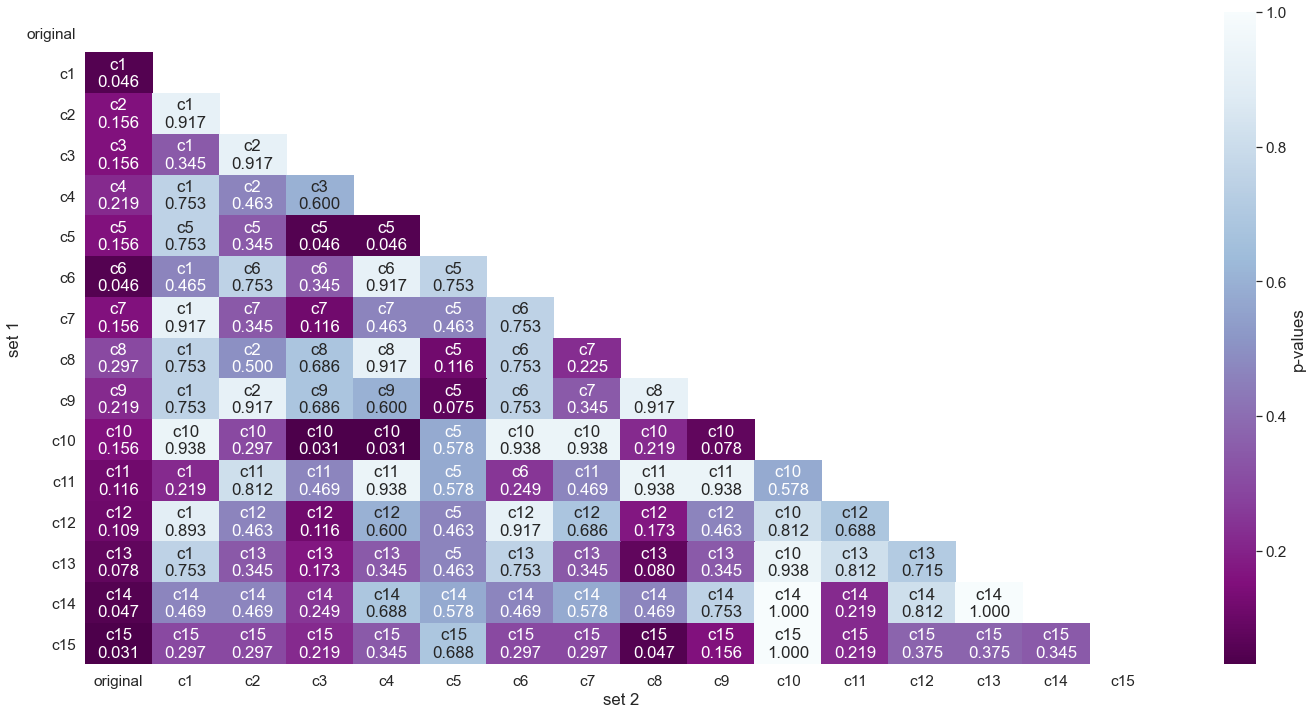

In [23]:
# Generate heatmap of p-values with winners

create_heatmap_with_winners(infectious_disease_wilcoxon_df, 'Heatmap of p-values | Wilcoxon test', 
                            'wilcoxon_heatmap_with_winners_infectious_disease')